# The evolution of cooperation

Why do members of the same species often cooperate? Why does it seem that
cooperation is evolutionarily beneficial, and how might this have come about? The economist and nobel laureate Robert Axelrod worked on these questions in the late 1970s and early 1980s. To investigate this question, he set up the following computer experiment. He investigated the performance of different strategies for playing the iterated prisoners dilemma. He set up a tournament where he invited colleagues to submit strategies. He informed them that the strategies would play the iterated prisoners dilemma for an unknown number of iterations. The aim was to design a strategy that would collect the most points while playing against all other submitted strategies. Some strategies that were submitted are

* **tit for tat** play nice, unless, in the previous move, the other player betrayed you.
* **contrite tit for tat**; play nice, unless, in the previous two moves, the other player betrayed you.
* **grim trigger** play nice until the other player betrays you after which you will always defect as well.
* **pavlov**; there is an entire family of pavlov strategies. The basic idea is that this strategy sticks to what was successful. The simplest version is if my and opponent move were the same last time, stay, else switch.
* **always defect**;
* **always cooperate**;

More details and variations on this can be found in 

* [Axelrod & Hamilton (1981) The evolution of cooperation, Science, Vol. 211, No. 4489](http://www-personal.umich.edu/~axe/research/Axelrod%20and%20Hamilton%20EC%201981.pdf)
* [Axelrod, Robert (1984), The Evolution of Cooperation, Basic Books, ISBN 0-465-02122-0](https://www.amazon.com/Evolution-Cooperation-Revised-Robert-Axelrod/dp/0465005640)

In this assignment, step by step, we are going to built a model for exploring how these different strategies perform when playing the iterated prisoners dilemma. In the first version, a set of strategies plays the iterated prisoner dilemma game against all other strategies, and we tally up the total scores. After that, we are going to slowly expand this model. First by adding some randomness to it. This is something that is very common in agent based modeling. Second, we are going to make the model dynamic by adding a small evolutionary mechanism to it. Third, we are going to combine the randomness and evolutionary dynamic.

## Developing a first model 
Below, we give the initial code you will be expanding on while developing
models of the emergence of cooperation. You can look at the code block below, or scroll further down where I explain this code in more detail.
   

In [1]:
from collections import deque
from enum import Enum
from itertools import combinations

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from mesa import Model, Agent


class Move(Enum):
    COOPERATE = 1
    DEFECT = 2


class AxelrodAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model)
        self.n_rounds = n_rounds
        self.points = 0
        self.noise_level = noise_level

    def step(self):
        """Playing the iterated prisoners dilemma agains all other agents in the model"""
        for other in self.model.agents:
            if other is self:
                # we don't play against ourselves
                continue
            for _ in range(self.n_rounds):
                move_a = self.move()
                move_b = other.move()

                #insert noise in movement, we
                if self.random.random() < self.noise_level:
                    if move_a == Move.COOPERATE:
                        move_a = Move.DEFECT
                    else:
                        move_a = Move.COOPERATE
                if self.random.random() < self.noise_level:
                    if move_b == Move.COOPERATE:
                        move_b = Move.DEFECT
                    else:
                        move_b = Move.COOPERATE                
                
                payoff_a, payoff_b = self.model.payoff_matrix[(move_a, move_b)]
                
                self.receive_payoff(payoff_a, move_a, move_b)
                other.receive_payoff(payoff_b, move_b, move_a)
            self.reset()
            other.reset()

    def move(self):
        """The move to make in this iteration of the game
        
        Returns:
            Move.COOPERATE or Move.DEFECT

        """
        
        raise NotImplementedError

    def receive_payoff(self, payoff, my_move, opponent_move):
        """Receive payoff and moves resulting in that payoff.

        Args:
            payoff : int
            my_move : {Move.COOPERATE, Move.DEFECT}
            opponents_move : {Move.COOPERATE, Move.DEFECT}

        """
        self.points += payoff
        
    def reset(self):
        """reset agent after completing playing agains another agent"""
        raise NotImplementedError
        

class TitForTat(AxelrodAgent):
    
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model, n_rounds, noise_level=noise_level) 
        self.opponent_last_move = Move.COOPERATE
    
    def move(self):
        return self.opponent_last_move
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        
    def reset(self):
        self.opponent_last_move = Move.COOPERATE


class ContriteTitForTat(AxelrodAgent):
    
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model, n_rounds, noise_level=noise_level) 
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)
    
    def move(self):
        if (self.opponent_last_two_moves[0] == Move.DEFECT) and\
           (self.opponent_last_two_moves[1] == Move.DEFECT):
            return Move.DEFECT
        else:
            return Move.COOPERATE
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_two_moves.append(opponent_move)
        
    def reset(self):
        self.opponent_last_two_moves = deque([Move.COOPERATE, Move.COOPERATE], maxlen=2)        


class AxelrodModel(Model):
    """A model with some number of agents."""
    def __init__(self, n, seed=None):
        super().__init__(seed=seed)
        self.payoff_matrix = {
            (Move.COOPERATE, Move.COOPERATE):(2, 2),
            (Move.COOPERATE, Move.DEFECT): (0, 3),
            (Move.DEFECT, Move.COOPERATE): (3, 0),
            (Move.DEFECT, Move.DEFECT): (1, 1)
        }
        
        # Create agents
        for agent_class in AxelrodAgent.__subclasses__():
            a = agent_class(self, n) 

    def step(self):
        """Advance the model by one step."""
        self.agents.do("step")
        

The above code gives the basic setup for a first version of a model of the evolution of cooperation. Let's quickly walk through this code. 

We begin with a number of import statements. We import the ``deque`` class
from the ``collections`` library. Deque is basically a pipeline of fixed
length. We put stuff in at one end, and stuff drops of at the other end. We
use the deque to create a memory of previous moves of a given length. See
the ``ContriteTitForTat`` class for how we use it. Next, we import the
``Enum`` class from the ``enum`` library. Enums are a way of specifying a
fixed number of unique names and associated values. We use it to standardize
 the 2 possible moves Agents can make. Next, we import the ``combinations`` function from the ``itertools`` library. We use this function to pair off all agents against one another. See the ``step`` method in the ``AxelrodModel`` class. The Python programming language comes with many useful libraries. It is well worth spending some time reading the detailed documentation for in particular itertools and collections. Many common tasks can readily be accomplished by using these libraries.

Next, we move to importing the ``Model`` and ``Agent`` classes from MESA. Agent is the base class from which all agents in a model have to be derived. Similarly, Model is the base class from which any given model is derived. 

Next, I have defined a generic ``AxelrodAgent``. Let's look at this class in a bit more detail starting with the first line

```python
class AxelrodAgent(Agent):
```

The word ``class`` is like ``def`` in that it indicates that we are describing something that can be used later. Here we are defining a class, which we can use by instantiating it as an object. We call this class ``AxelrodAgent`` and it extends (i.e. is a further detailing of) the base ``Agent`` class that we imported from Mesa.

This AxelrodAgent has 4 methods

```python
    def __init__(self, model, n_rounds, noise_level=0): 
        ...

    def step(self):
        ...

    def move(self):
        ...

    def receive_payoff(self, payoff, my_move, opponent_move):
         ...
        
    def reset(self):
        ...

```
Any method in Python has as its first variable ``self``. This is not
something that you need to pass when calling the method. It is something automatically inserted by Python. Self refers to this specific instance of the class (i.e., the object), and it allows you to assign values to it or call methods on itself.

The first method, ``__init__`` is common to any Python class. This method is called when instantiating the class as an object. The first variable in the ``__init__``, ``model``, is expected by MESA. `n_rounds` and `noise_level` are an argument and keyword argument respectively that we'll be using in this assignment. The ``step`` method is also expected by Mesa. The other three methods `move`, ``receive_payoff`` and ``reset``,have been chosen by me. Note how we are specifying, implicitly, a pattern of interaction. Each of these methods is called under specific conditions and does something to the state of the agent (make a move in one round of the iterated prisoners dilemma, receive payoff, and reset). `move` is called for each iteration of a single instance of the iterated prisoners dilemma. ``receive_payoff`` is called after each round of the prisoners dilemma. ``reset`` is called after having played the iterated prisoners dilemma against another strategy for `n_rounds`.

This pattern of interaction is captured in `AxelrodAgent.step`. Here, we specify that a given agent is playing the iterated prisoners dilmema against all other agents in the model. Of course, an agent won't play against itself, so we check fo this and skip it. Given another agent, the game is played for `n_rounds`. Both agents make their move. Next, there is a small code block to insert noise (i.e., flip the intended move) that will be used later. Because by default `noise_level=0`, this code blcok is effectively skipped. Given the actual moves, we can get the payoff, and inform both agents of this payoff and the other agent's move. Once this game has been played for `n_rounds`, both players are reset for a next game. 

```python
    def step(self):
        """Playing the iterated prisoners dilemma agains all other agents in the model"""
        for other in self.model.agents:
            if other is self:
                # we don't play against ourselves
                continue
            for _ in range(self.n_rounds):
                move_a = self.move()
                move_b = other.move()

                #insert noise in movement, we
                if self.random.random() < self.noise_level:
                    if move_a == Move.COOPERATE:
                        move_a = Move.DEFECT
                    else:
                        move_a = Move.COOPERATE
                if self.random.random() < self.noise_level:
                    if move_b == Move.COOPERATE:
                        move_b = Move.DEFECT
                    else:
                        move_b = Move.COOPERATE                
                
                payoff_a, payoff_b = self.model.payoff_matrix[(move_a, move_b)]
                
                self.receive_payoff(payoff_a, move_a, move_b)
                other.receive_payoff(payoff_b, move_b, move_a)
            self.reset()
            other.reset()

```

Of the 5 methods, 3 are implemented and 2 raise an error. Any specific strategy class that we are going to implement thus needs to implement always at least the move and reset method, while it can rely on the behavior of ``__init__`` and ``receive_payoff``, extend this behavior, or overwrite it. Let's look at these three options in some more detail.

If a subclass of AxelrodAgent does not implement either ``__init__`` and ``receive_payoff``, it automatically falls back on using the behavior specified in the AxelrodAgent class. We can also extend the behavior. For this look at the ``TitForTat`` class:

```python
class TitForTat(AxelrodAgent):
    
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model, n_rounds, noise_level=noise_level) 
        self.opponent_last_move = Move.COOPERATE
    
    def move(self):
        return self.opponent_last_move
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        
    def reset(self):
        self.opponent_last_move = Move.COOPERATE
```

Note how both ``__init__`` and ``receive_payoff`` start with ``super()``. This means that we first call the same method on the parent class (so ``AxelrodAgent``). Next we have some additional things we want to do. In ``__init__`` we create a novel attribute ``opponent_last_move``, which we set to ``Move.COOPERATE``. Note how we use the ``self`` variable. In receive_payoff, we update this attribute. Finally, we can overwrite the entire implementation of a method. For this, all we need to do is not call super.

# Assignment 1: implementing your first strategies
Before looking at the model class more closely, Implement the following strategies as classes (in order of easy to difficult)

* **Defector**; always defect
* **Cooperator**; always cooperate
* **GrimTrigger**; cooperate until betrayed, after which it always defects
* **Pavlov**; The basic idea is that this strategy sticks to what was successful. The simplest version is if my and opponent move were the same last time, stay, else switch. Pavlov always starts assuming in the previous move, both agents played ``Move.COOPERATE``

To help you, I have given you the basic template and all you need to do is write some code replacing the dots.

In [2]:
class Defector(AxelrodAgent):
    def move(self):
        return Move.DEFECT
    
    def reset(self):
        pass


class Cooperator(AxelrodAgent):
    def move(self):
        return Move.COOPERATE
    
    def reset(self):
        pass


class GrimTrigger(AxelrodAgent):
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model, n_rounds, noise_level=noise_level) 
        self.betrayed = False
    
    def move(self):
        if self.betrayed:
            return Move.DEFECT
        else:
            return Move.COOPERATE
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        if opponent_move == Move.DEFECT:
            self.betrayed = True
        
    def reset(self):
        self.betrayed = False


class Pavlov(AxelrodAgent):
    def __init__(self, model, n_rounds, noise_level=0): 
        super().__init__(model, n_rounds, noise_level=noise_level) 
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE        
    
    def move(self):
        if self.opponent_last_move == self.my_last_move:
            my_move = self.my_last_move
        else:
            my_move = self.opponent_last_move
        return my_move
    
    def receive_payoff(self, payoff, my_move, opponent_move):
        super().receive_payoff(payoff, my_move, opponent_move)
        self.opponent_last_move = opponent_move
        self.my_last_move = my_move
        
    def reset(self):
        self.opponent_last_move = Move.COOPERATE
        self.my_last_move = Move.COOPERATE 

Before running the model, let's quickly walk through the code of the model class.

```python
class AxelrodModel(Model):
```

So, here we define a new model class which extends the default model class from MESA. This class typically has at least 2 methods: ``__init__`` and ``step``. In the init we instantiate the model, while in step we specify what should happen in one step of the model. A step, or tick, is something particular to Agent Based Models. A step generally involves allowing all agents to take an action (i.e. you call step on all agents). 

Lets' look more closely at the init

```python
def __init__(self, N, seed=None):
    super().__init__(seed=seed)
    self.num_iterations = N
    self.payoff_matrix = {}

    self.payoff_matrix[(Move.COOPERATE, Move.COOPERATE)] = (2, 2)
    self.payoff_matrix[(Move.COOPERATE, Move.DEFECT)] = (0, 3)
    self.payoff_matrix[(Move.DEFECT, Move.COOPERATE)] = (3, 0)
    self.payoff_matrix[(Move.DEFECT, Move.DEFECT)] = (1, 1)

    # Create agents
    for agent_class in AxelrodAgent.__subclasses__():
        a = agent_class(self)
```

we are extending the default ``__init__`` from ``Model``, so we call
``super`` first. Next, we specify the model's attribute: the payoff matrix. Note that a high payoff is desirable. Next we populate the model with one instance of each type of strategy.

```python
for agent_class in AxelrodAgent.__subclasses__():
```

``AxelrodAgent.__subclasses__()`` is a python *magic* method as indicated by the leading and trailing double underscore. Moreover, this is a so-called class method. Remember, when introducing object oriented programming, I said that methods are tied to objects (i.e., instances of the class). This is 95% true, but it is possible to define methods (and attributes) at the class level as well. These are useful for doing tasks that don't rely on the state of the object but are relevant to the behavior of the class. Don't worry too much about getting your head around this. It is a rather advanced and esoteric topic that we don't need to worry about too much. Here, ``__subclasses__`` returns a list with all classes that extend ``AxelrodAgent``. That is, all the different strategies we hve been defining. Note that this also showcases a benefit of using Object Orientation. If we implement new strategies, as long as they extend ``AxelrodAgent``, we don't have to change the model itself. It will just work.

Next, let's look at the step method. Basically, here we let all againts play by calling the `step` method on all agents.

```python
def step(self):
    '''Advance the model by one step.'''
    self.agents.do("step")
```


We can now run the model and get the scores out.

```python
scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
```
Here we iterate over all agents, and use magic attributes to get the class name and the points accumulated over playing against all other strategies. Next, we sort this list in place based on the number of points, and sort it in reverse order.

```python
scores.sort(key=lambda x: x[1], reverse=True)
```



In [3]:
model = AxelrodModel(200)
model.step()

scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
scores.sort(key=lambda x: x[1], reverse=True)
for entry in scores:
    print(entry)

('TitForTat', 3598)
('GrimTrigger', 3598)
('Pavlov', 3598)
('ContriteTitForTat', 3596)
('Cooperator', 3200)
('Defector', 2820)


# Assignment 2: adding a random agent

The strategies we have been looking at so far are deterministic. Let's make this story a bit more complicated. Below, implement an additional strategy whose moves are random with an equal chance of either cooperate or defect. How does this change the results? If you rerun this model multiple times, what do you see? Why does this happen?

*tip: it is a best practice in MESA to use ``self.random`` on any instance of a Mesa agent or model*

In [4]:
class Random(AxelrodAgent):
    
    def move(self):
        if self.random.random() < 0.5:
            return Move.COOPERATE
        else:
            return Move.DEFECT
        
    def reset(self):
        pass
    
for _ in range(10):
    model = AxelrodModel(200)
    model.step()

    scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
    scores.sort(key=lambda x: x[1], reverse=True)
    for entry in scores:
        print(entry)
    print()

('GrimTrigger', 4390)
('TitForTat', 4202)
('Pavlov', 4186)
('ContriteTitForTat', 4102)
('Defector', 3628)
('Cooperator', 3586)
('Random', 3414)

('GrimTrigger', 4394)
('Pavlov', 4220)
('TitForTat', 4199)
('ContriteTitForTat', 4104)
('Defector', 3640)
('Cooperator', 3592)
('Random', 3445)

('GrimTrigger', 4398)
('Pavlov', 4195)
('TitForTat', 4191)
('ContriteTitForTat', 4101)
('Defector', 3640)
('Cooperator', 3600)
('Random', 3394)

('GrimTrigger', 4430)
('TitForTat', 4207)
('Pavlov', 4197)
('ContriteTitForTat', 4105)
('Defector', 3652)
('Cooperator', 3596)
('Random', 3384)

('GrimTrigger', 4385)
('TitForTat', 4208)
('Pavlov', 4196)
('ContriteTitForTat', 4090)
('Defector', 3608)
('Cooperator', 3564)
('Random', 3455)

('GrimTrigger', 4395)
('TitForTat', 4206)
('Pavlov', 4204)
('ContriteTitForTat', 4107)
('Defector', 3614)
('Cooperator', 3600)
('Random', 3431)

('GrimTrigger', 4371)
('TitForTat', 4209)
('Pavlov', 4203)
('ContriteTitForTat', 4095)
('Cooperator', 3636)
('Defector', 3626)
('R

## pseudo random number generation

By adding an agent which plays a random move, we introduce randomness in the outcomes of the model. Every time we run the model, the payoffs received by each strategy will be slightly different. This might create all kinds of issues. For example, what if you have an error in your code that only occurs under very specific conditions. How can you ensure that these conditions occur when debugging if randomness plays a role? Or, how can we draw conclusions from results that are not deterministic?

Randomness is intrinsic to virtually all agent based models. Computers don't actually produce real random numbers, but rather rely on deterministic algorithms that produce numbers that appear very close to random. Such algorithms are known as pseudo-random number generators. As long as we know the initial state of this algorithm, we can reproduce the exact same random numbers. If you want to know more, the [Wikipedia entry on Random Number Generation](https://en.wikipedia.org/wiki/Random_number_generation) is a good starting point. So how can we control this state?

It is here that the ``seed`` argument comes in. Remember our model ``__init__`` function had ``seed`` as an optional keyword argument set to ``None`` by default. By providing a specific value, we can actually make the random numbers deterministic. Have a look at the code below to see this in action.

In [5]:
import random
random.seed(123456789)
[random.random() for _ in range(10)]

[0.6414006161858726,
 0.5421892680969495,
 0.9931750662832721,
 0.8432521366869166,
 0.8117339283379406,
 0.3971737100780004,
 0.9370951079120425,
 0.6891026531658162,
 0.39711048852598374,
 0.35102519242304475]

In [6]:
random.seed(123456789)
[random.random() for _ in range(10)]

[0.6414006161858726,
 0.5421892680969495,
 0.9931750662832721,
 0.8432521366869166,
 0.8117339283379406,
 0.3971737100780004,
 0.9370951079120425,
 0.6891026531658162,
 0.39711048852598374,
 0.35102519242304475]

By setting seed to the same value in both code blocks, we start the generation of random numbers from the same initial condition. Thus, the random numbers are the same. If seed is set to None, the computer will look at the time and use this as initial condition.

# Assignment 3: Noise

In the foregoing, we have explored how well different strategies for playing the iterated prisoners dilemma perform assuming that there is no noise. That is, the moves of agents are executed as intended. Next, let's complicate the situation. What happens if there is a small chance that an agent makes the opposite move from what it intended to do?

For this, we can adapt the model itself. If you have implemented the strategies smartly, there is no need to change anything in the strategy classes. Modify the model in the following way:
* There is a user specifiable probability of making the opposite move. This probability is constant for all agents.



In [7]:
class AxelrodModelWithNoise(Model):
    """A model with some number of agents."""
    def __init__(self, n, noise_level=0, seed=None):
        super().__init__(seed=seed)
        self.payoff_matrix = {
            (Move.COOPERATE, Move.COOPERATE):(2, 2),
            (Move.COOPERATE, Move.DEFECT): (0, 3),
            (Move.DEFECT, Move.COOPERATE): (3, 0),
            (Move.DEFECT, Move.DEFECT): (1, 1)
        }
        
        # Create agents
        for agent_class in AxelrodAgent.__subclasses__():
            a = agent_class(self, n, noise_level) 

    def step(self):
        """Advance the model by one step."""
        self.agents.do("step")

In [8]:
model = AxelrodModelWithNoise(200, noise_level=0.1)
model.step()

scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
scores.sort(key=lambda x: x[1], reverse=True)
for entry in scores:
    print(entry)

('Defector', 3918)
('GrimTrigger', 3862)
('Pavlov', 3596)
('TitForTat', 3563)
('Random', 3537)
('ContriteTitForTat', 3431)
('Cooperator', 2798)


Experiment with different levels of noise, ranging from 1% to 10%, how does this affect the ranking of the strategies?

you can use ``np.linspace`` to generate a range of evenly spaced values between 0.01 and 0.1. You can use the above code for printing the scores of a given run to the screen.

In [9]:
for noise_level in np.linspace(0.01, 0.1, 10):
    model = AxelrodModelWithNoise(200, noise_level=noise_level)
    model.step()

    print(noise_level)
    scores = [(agent.__class__.__name__, agent.points) for agent in model.agents]
    scores.sort(key=lambda x: x[1], reverse=True)
    for entry in scores:
        print(entry)
    
    print()

0.01
('ContriteTitForTat', 3941)
('GrimTrigger', 3916)
('TitForTat', 3759)
('Pavlov', 3679)
('Defector', 3618)
('Random', 3380)
('Cooperator', 3130)

0.020000000000000004
('GrimTrigger', 3888)
('TitForTat', 3786)
('ContriteTitForTat', 3784)
('Pavlov', 3686)
('Defector', 3661)
('Random', 3439)
('Cooperator', 2893)

0.030000000000000006
('GrimTrigger', 3818)
('Defector', 3707)
('ContriteTitForTat', 3651)
('Pavlov', 3600)
('TitForTat', 3598)
('Random', 3420)
('Cooperator', 2792)

0.04000000000000001
('Defector', 3751)
('GrimTrigger', 3663)
('Pavlov', 3640)
('TitForTat', 3612)
('ContriteTitForTat', 3586)
('Random', 3444)
('Cooperator', 3019)

0.05000000000000001
('GrimTrigger', 3908)
('Defector', 3716)
('ContriteTitForTat', 3686)
('TitForTat', 3610)
('Pavlov', 3609)
('Random', 3428)
('Cooperator', 2847)

0.06000000000000001
('Defector', 3774)
('GrimTrigger', 3766)
('TitForTat', 3638)
('Pavlov', 3605)
('ContriteTitForTat', 3484)
('Random', 3461)
('Cooperator', 2839)

0.07
('GrimTrigger', 38

# Assignment 4: adding evolutionary dynamics

Up till now, we have run the model for only one step. That is all agents play against each other only once. Let's make the model more dynamic by adding an evolutionary component to it. We start by generating *M* agents of each strategy. These agents play against one another as before. Next, after each step, we tally up the total scores achieved by each strategy. We create a new population, proportional to how well each strategy performed. Over multiple steps, badly performing strategies will die out. However, with changing proportions of the different strategies, how well each strategy is performing will also change. Can you predict which strategies will come to dominate this population?

1. Implement the ``build_population`` method which creates a population given a dictionary with proportions
2. Calculate the new proportions as part of ``step``

*hint: check the agentset documentation and look at groupby operations which are very similar to how this works in pandas*

To help in keeping track of the changing proportions over time, I have added a small piece of code. In the ``__init__`` we create an attribute with the scores. This attribute is a dictionary with a list for each class of agents. In ``step`` we append the new proportions to these lists.


In [10]:
from collections import defaultdict

class EvolutionaryAxelrodModel(Model):
    """A model with some number of agents."""
    def __init__(self, num_agents, n, seed=None, noise_level=0):
        super().__init__(seed=seed)
        self.payoff_matrix = {
            (Move.COOPERATE, Move.COOPERATE):(2, 2),
            (Move.COOPERATE, Move.DEFECT): (0, 3),
            (Move.DEFECT, Move.COOPERATE): (3, 0),
            (Move.DEFECT, Move.DEFECT): (1, 1)
        }
        
        self.population_size = len(AxelrodAgent.__subclasses__())*num_agents
        self.noise_level = noise_level
        
        strategies = AxelrodAgent.__subclasses__()
        num_strategies = len(strategies)
        proportions = {agent_class:1/num_strategies for agent_class in strategies}

        self.num_iterations = n
        self.scores = defaultdict(list)
        for agent_class in strategies:
            self.scores[agent_class].append(proportions[agent_class])        
        
        self.initial_population_size = num_agents * num_strategies
        self.build_population(proportions)


    def remove_population(self):
        for agent in list(self._agents.keys()):
            agent.remove()

    
    def build_population(self, proportions):
        for agent_class, proportion in proportions.items():
            num_agents = round(self.initial_population_size*proportion)

            for _ in range(num_agents):
                a = agent_class(self, self.num_iterations, noise_level=noise_level)
    
    
    def step(self):
        """Advance the model by one step."""
        for agent in self.agents:
            agent.step()

        # calculate scores per class of agents
        scores = self.agents.groupby(type).agg("points", sum)
        
        # normalize scores on unit interval
        total = sum(scores.values())
        proportions = {k:v/total for k,v in scores.items()}
        
        # keep track of proportions over the generations
        for agent_class in AxelrodAgent.__subclasses__():
            self.scores[agent_class].append(proportions[agent_class])
        
        self.remove_population()
        self.build_population(proportions)


Instantiate the model with 10 agents per strategy and play 200 rounds of the game. Next run the model for 50 steps and visualize how the relative proportions of the different strategies evolve over the steps.

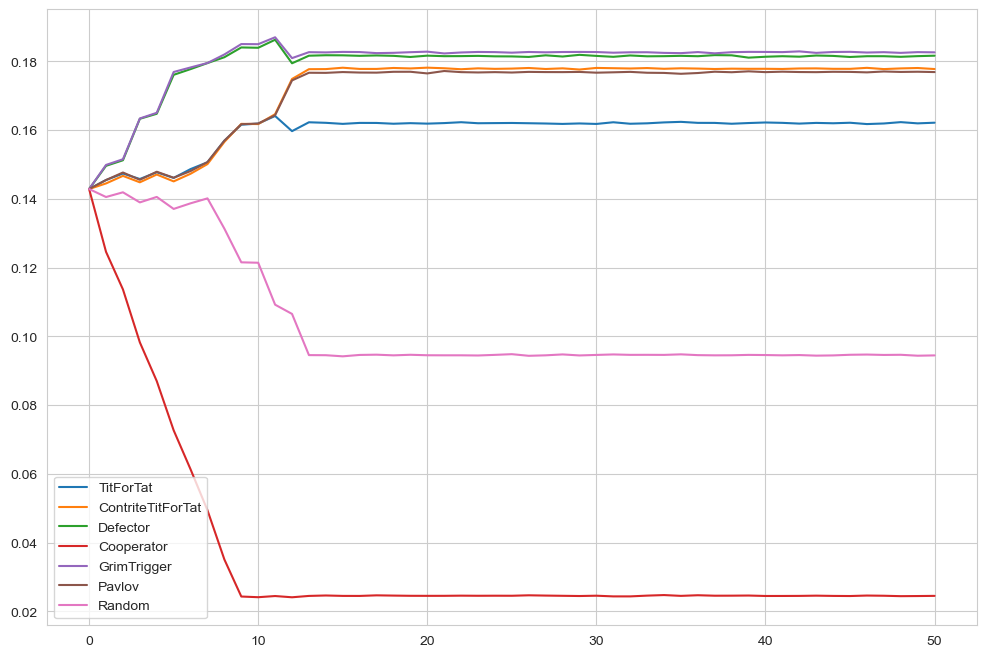

In [11]:
model = EvolutionaryAxelrodModel(10, 200)

for _ in range(50):
    model.step()

# visualizing results using matplotlib
fig, ax = plt.subplots()
for k, v in model.scores.items():
    ax.plot(v, label=k.__name__)
ax.legend()
plt.show()



# Assignment 5: Evolution with noise

Building on the previous two versions of the model, as a final step we are going to explore how noise affects the evolutionary dynamics. To do this, you use the Evolutionary model from the previous step but vary `noise_level`. Again, explore the dynamics of this model for 50 steps over noise levels ranging from 1% to 10%. What do you see? Can you explain what is happening in the model? Are you surprised by these results?


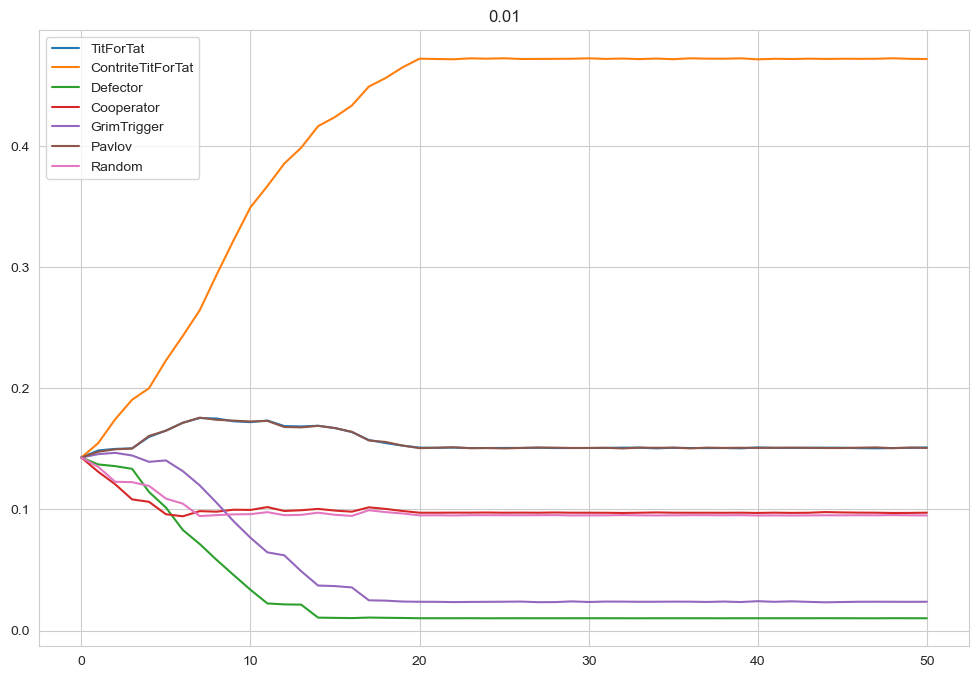

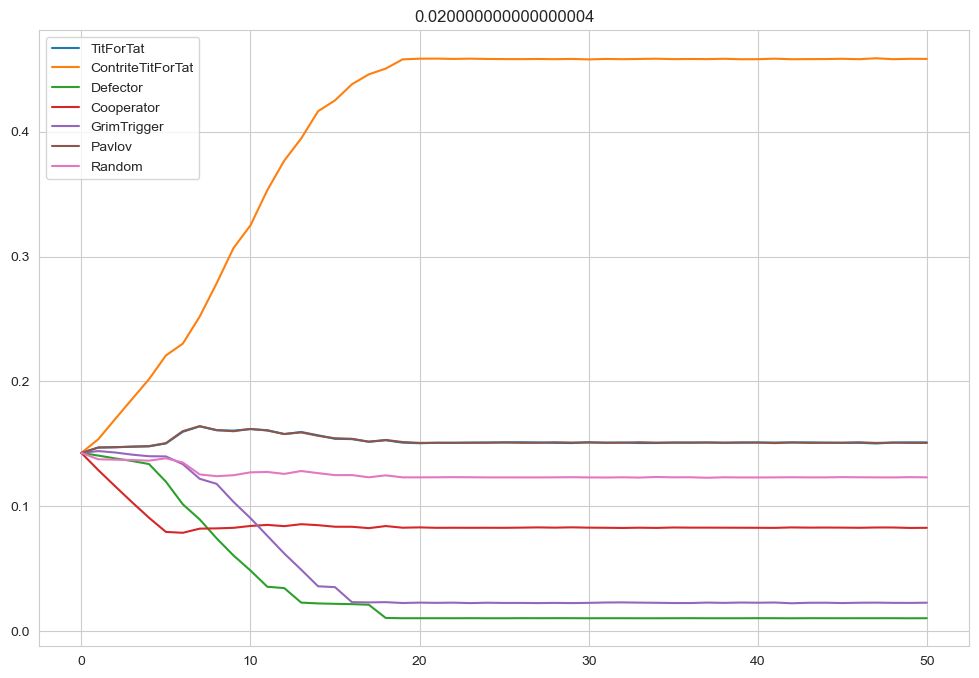

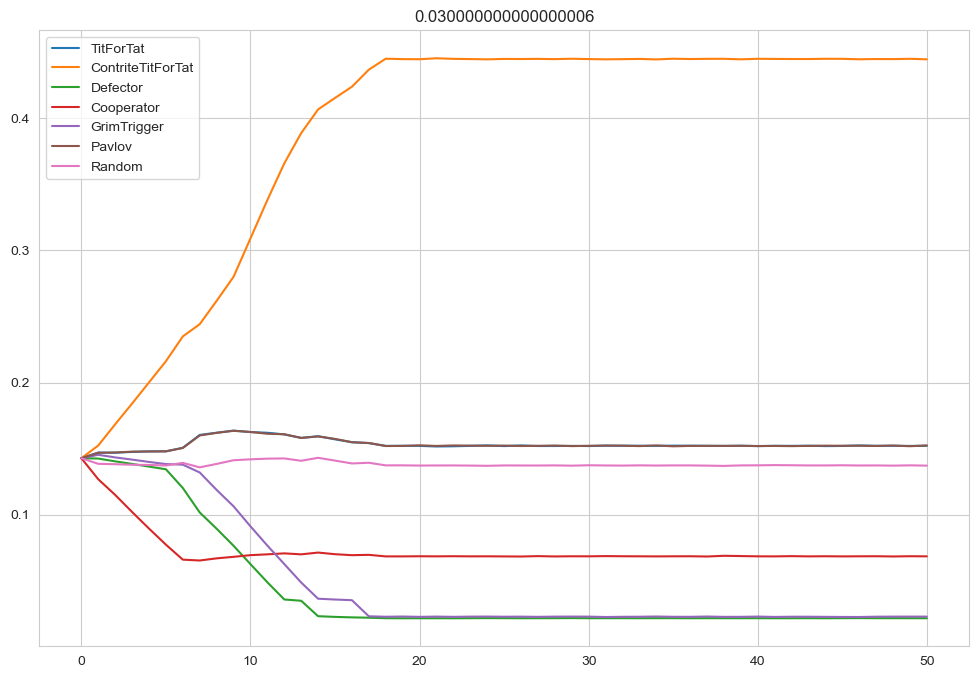

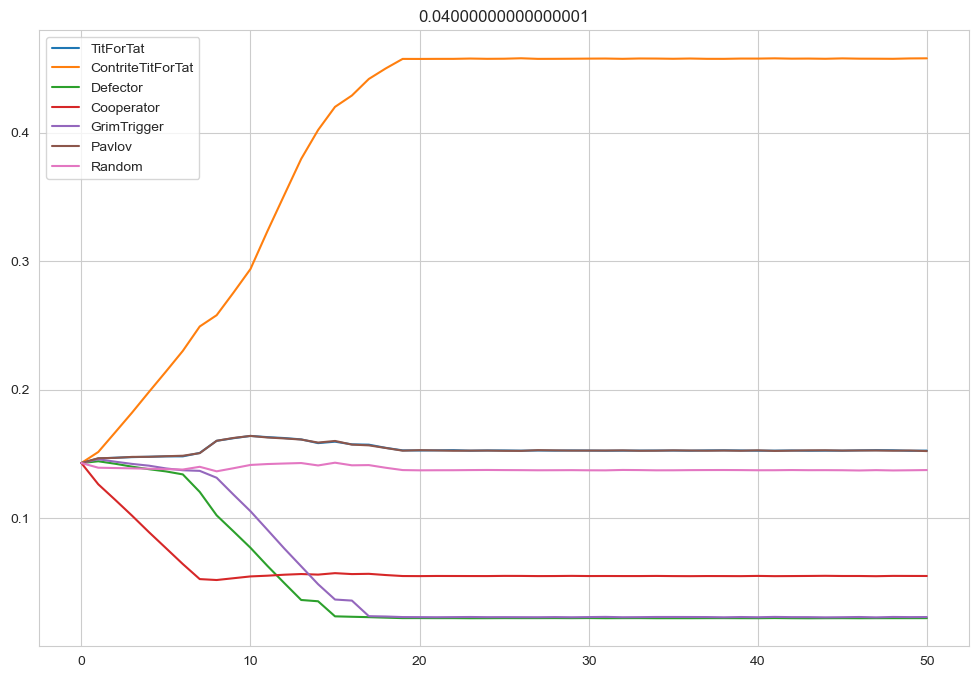

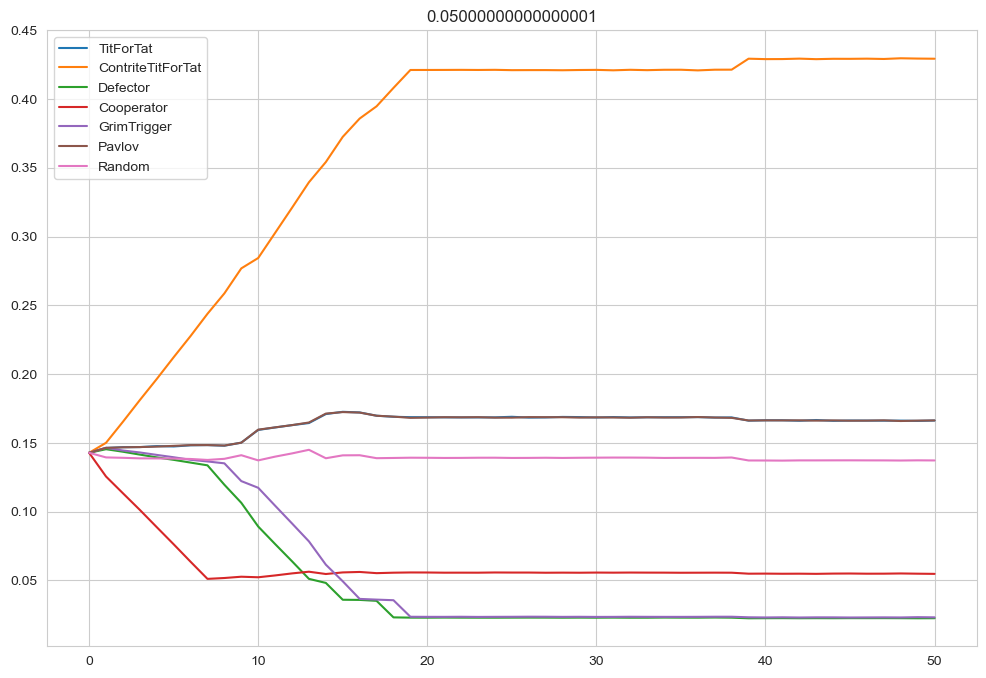

In [ ]:
for noise_level in np.linspace(0.01, 0.1, 10):
    model = EvolutionaryAxelrodModel(10, 200, noise_level=noise_level)

    for _ in range(50):
        model.step()

    # visualizing results using matplotlib
    fig, ax = plt.subplots()
    for k, v in model.scores.items():
        ax.plot(v, label=k.__name__)
    ax.legend()
    ax.set_title(noise_level)
    plt.show()


